# LSTM

In [1]:
import numpy as np
from matplotlib import pyplot as plt

In [2]:
# 输出单元激活函数
def softmax(x):
    x = np.array(x)
    max_x = np.max(x)
    return np.exp(x-max_x) / np.sum(np.exp(x-max_x))
 
def sigmoid(x):
    return 1.0/(1.0 + np.exp(-x))
 
def tanh(x):
    return (np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x))


In [3]:
class myLSTM(object):
    def __init__(self, data_dim, hidden_dim=100):
        # data_dim: 词向量维度，即词典长度; hidden_dim: 隐单元维度
        self.data_dim = data_dim
        self.hidden_dim = hidden_dim
 
        # 初始化权重向量 
        self.whi, self.wxi, self.bi = self._init_wh_wx()
        
        print(self.wxi.shape)
        self.whf, self.wxf, self.bf = self._init_wh_wx()                           
        self.who, self.wxo, self.bo = self._init_wh_wx()
        self.wha, self.wxa, self.ba = self._init_wh_wx()
        self.wy, self.by = np.random.uniform(-np.sqrt(1.0/self.hidden_dim), np.sqrt(1.0/self.hidden_dim), 
                                   (self.data_dim, self.hidden_dim)), \
                           np.random.uniform(-np.sqrt(1.0/self.hidden_dim), np.sqrt(1.0/self.hidden_dim), 
                                   (self.data_dim, 1))
 
    # 初始化 wh, wx, b
    def _init_wh_wx(self):
        wh = np.random.uniform(-np.sqrt(1.0/self.hidden_dim), np.sqrt(1.0/self.hidden_dim), 
                                   (self.hidden_dim, self.hidden_dim))
        wx = np.random.uniform(-np.sqrt(1.0/self.data_dim), np.sqrt(1.0/self.data_dim), 
                                   (self.hidden_dim, self.data_dim))
        b = np.random.uniform(-np.sqrt(1.0/self.data_dim), np.sqrt(1.0/self.data_dim), 
                                   (self.hidden_dim, 1))
 
        return wh, wx, b
 
    # 初始化各个状态向量
    def _init_s(self, T):
        iss = np.array([np.zeros((self.hidden_dim, 1))] * (T + 1))  # input gate
        fss = np.array([np.zeros((self.hidden_dim, 1))] * (T + 1))  # forget gate
        oss = np.array([np.zeros((self.hidden_dim, 1))] * (T + 1))  # output gate
        ass = np.array([np.zeros((self.hidden_dim, 1))] * (T + 1))  # current inputstate
        hss = np.array([np.zeros((self.hidden_dim, 1))] * (T + 1))  # hidden state
        css = np.array([np.zeros((self.hidden_dim, 1))] * (T + 1))  # cell state
        ys = np.array([np.zeros((self.data_dim, 1))] * T)    # output value
 
        return {'iss': iss, 'fss': fss, 'oss': oss, 
                'ass': ass, 'hss': hss, 'css': css, 
                'ys': ys}
     
    def plot_loss():
        x = np.arange(0,len(self.losses))
        plt.plot(x,losses)
        plt.show()
        
    # 前向传播，单个x
    def forward(self, x):
        # 向量时间长度
        T = len(x)        
        # 初始化各个状态向量
        stats = self._init_s(T)               
 
        for t in range(T):
            # 前一时刻隐藏状态
            ht_pre = np.array(stats['hss'][t-1]).reshape(-1, 1)
 
            # input gate
            stats['iss'][t] = self._cal_gate(self.whi, self.wxi, self.bi, ht_pre, x[t], sigmoid)
            # forget gate
            stats['fss'][t] = self._cal_gate(self.whf, self.wxf, self.bf, ht_pre, x[t], sigmoid)
            # output gate
            stats['oss'][t] = self._cal_gate(self.who, self.wxo, self.bo, ht_pre, x[t], sigmoid)
            # current inputstate
            stats['ass'][t] = self._cal_gate(self.wha, self.wxa, self.ba, ht_pre, x[t], tanh)
 
            # cell state, ct = ft * ct_pre + it * at
            stats['css'][t] = stats['fss'][t] * stats['css'][t-1] + stats['iss'][t] * stats['ass'][t]            
            # hidden state, ht = ot * tanh(ct)
            stats['hss'][t] = stats['oss'][t] * tanh(stats['css'][t])
 
            # output value, yt = softmax(self.wy.dot(ht) + self.by)
            stats['ys'][t] = softmax(self.wy.dot(stats['hss'][t]) + self.by)
 
        return stats
 
    # 计算各个门的输出
    def _cal_gate(self, wh, wx, b, ht_pre, x, activation):
        return activation(wh.dot(ht_pre) + wx[:, x].reshape(-1,1) + b)
 
    # 预测输出，单个x    
    def predict(self, x):
        stats = self.forward(x)
        pre_y = np.argmax(stats['ys'].reshape(len(x), -1), axis=1)         
        return pre_y
 
    # 计算损失， softmax交叉熵损失函数， (x,y)为多个样本
    def loss(self, x, y):
        cost = 0        
        for i in range(len(y)):
            stats = self.forward(x[i])
            # 取出 y[i] 中每一时刻对应的预测值
            pre_yi = stats['ys'][range(len(y[i])), y[i]]
            cost -= np.sum(np.log(pre_yi))
 
        # 统计所有y中词的个数, 计算平均损失
        N = np.sum([len(yi) for yi in y])
        ave_loss = cost / N
 
        return ave_loss
 
     # 初始化偏导数 dwh, dwx, db
    def _init_wh_wx_grad(self):
        dwh = np.zeros(self.whi.shape)
        dwx = np.zeros(self.wxi.shape)
        db = np.zeros(self.bi.shape)
 
        return dwh, dwx, db
 
    # 求梯度, (x,y)为一个样本
    def bptt(self, x, y):
        dwhi, dwxi, dbi = self._init_wh_wx_grad()
        dwhf, dwxf, dbf = self._init_wh_wx_grad()                           
        dwho, dwxo, dbo = self._init_wh_wx_grad()
        dwha, dwxa, dba = self._init_wh_wx_grad()
        dwy, dby = np.zeros(self.wy.shape), np.zeros(self.by.shape)
 
        # 初始化 delta_ct，因为后向传播过程中，此值需要累加
        delta_ct = np.zeros((self.hidden_dim, 1))
 
        # 前向计算
        stats = self.forward(x)
        # 目标函数对输出 y 的偏导数
        delta_o = stats['ys']
        delta_o[np.arange(len(y)), y] -= 1
 
        for t in np.arange(len(y))[::-1]:
            # 输出层wy, by的偏导数，由于所有时刻的输出共享输出权值矩阵，故所有时刻累加
            dwy += delta_o[t].dot(stats['hss'][t].reshape(1, -1))  
            dby += delta_o[t]
 
            # 目标函数对隐藏状态的偏导数
            delta_ht = self.wy.T.dot(delta_o[t])
 
            # 各个门及状态单元的偏导数
            delta_ot = delta_ht * tanh(stats['css'][t])
            delta_ct += delta_ht * stats['oss'][t] * (1-tanh(stats['css'][t])**2)
            delta_it = delta_ct * stats['ass'][t]
            delta_ft = delta_ct * stats['css'][t-1]
            delta_at = delta_ct * stats['iss'][t]
 
            delta_at_net = delta_at * (1-stats['ass'][t]**2)
            delta_it_net = delta_it * stats['iss'][t] * (1-stats['iss'][t])
            delta_ft_net = delta_ft * stats['fss'][t] * (1-stats['fss'][t])
            delta_ot_net = delta_ot * stats['oss'][t] * (1-stats['oss'][t])
 
            # 更新各权重矩阵的偏导数，由于所有时刻共享权值，故所有时刻累加
            dwhf, dwxf, dbf = self._cal_grad_delta(dwhf, dwxf, dbf, delta_ft_net, stats['hss'][t-1], x[t])                              
            dwhi, dwxi, dbi = self._cal_grad_delta(dwhi, dwxi, dbi, delta_it_net, stats['hss'][t-1], x[t])                              
            dwha, dwxa, dba = self._cal_grad_delta(dwha, dwxa, dba, delta_at_net, stats['hss'][t-1], x[t])            
            dwho, dwxo, dbo = self._cal_grad_delta(dwho, dwxo, dbo, delta_ot_net, stats['hss'][t-1], x[t])
 
        return [dwhf, dwxf, dbf, 
                dwhi, dwxi, dbi, 
                dwha, dwxa, dba, 
                dwho, dwxo, dbo, 
                dwy, dby]
 
    # 更新各权重矩阵的偏导数            
    def _cal_grad_delta(self, dwh, dwx, db, delta_net, ht_pre, x):
        dwh += delta_net * ht_pre
        dwx += delta_net * x
        db += delta_net
 
        return dwh, dwx, db
 
    # 计算梯度, (x,y)为一个样本
    def sgd_step(self, x, y, learning_rate):
        dwhf, dwxf, dbf, \
        dwhi, dwxi, dbi, \
        dwha, dwxa, dba, \
        dwho, dwxo, dbo, \
        dwy, dby = self.bptt(x, y)
 
        # 更新权重矩阵
        self.whf, self.wxf, self.bf = self._update_wh_wx(learning_rate, self.whf, self.wxf, self.bf, dwhf, dwxf, dbf)
        self.whi, self.wxi, self.bi = self._update_wh_wx(learning_rate, self.whi, self.wxi, self.bi, dwhi, dwxi, dbi)
        self.wha, self.wxa, self.ba = self._update_wh_wx(learning_rate, self.wha, self.wxa, self.ba, dwha, dwxa, dba)
        self.who, self.wxo, self.bo = self._update_wh_wx(learning_rate, self.who, self.wxo, self.bo, dwho, dwxo, dbo)
 
        self.wy, self.by = self.wy - learning_rate * dwy, self.by - learning_rate * dby
 
    # 更新权重矩阵
    def _update_wh_wx(self, learning_rate, wh, wx, b, dwh, dwx, db):
        wh -= learning_rate * dwh
        wx -= learning_rate * dwx
        b -= learning_rate * db
 
        return wh, wx, b
    # 训练 LSTM
    def train(self, X_train, y_train, learning_rate=0.005, n_epoch=5):
        losses = []
        num_examples = 0
 
        for epoch in range(n_epoch):   
            for i in range(len(y_train)):
                self.sgd_step(X_train[i], y_train[i], learning_rate)
                num_examples += 1
                if i%200 ==0:
                    
                    loss = self.loss(X_train, y_train)
                    print ('-'*8+'epoch {0} batch = {1}: loss = {2}'.format(epoch+1, i , loss)+'-'*8)
                    losses.append(loss)

            loss = self.loss(X_train, y_train)
            losses.append(loss)
            print ('-'*15+'epoch {0}: loss = {1}'.format(epoch+1, loss)+'-'*15)
            if len(losses) > 1 and losses[-1] > losses[-2]:
                learning_rate *= 0.5
                print( 'decrease learning_rate to', learning_rate)
        self.losses = losses

### 数据准备


In [18]:
# 最多8位二进制
BINARY_DIM = 8

# 将整数表示成为binary_dim位的二进制数，高位用0补齐
def int_2_binary(number, binary_dim):
    binary_list = list(map(lambda x: int(x), bin(number)[2:]))
    number_dim = len(binary_list)
    result_list = [0]*(binary_dim-number_dim)+binary_list
    return result_list

# 将一个二进制数组转为整数
def binary2int(binary_array):
    out = 0
    for index, x in enumerate(reversed(binary_array)):
        out += x * pow(2, index)
    return out

# 将[0,2**BINARY_DIM)所有数表示成二进制
binary = np.array([int_2_binary(x, BINARY_DIM) for x in range(2**BINARY_DIM)])
# print(binary)

# 样本的输入向量和输出向量
dataX = []
dataY = []
for i in range(binary.shape[0]):
    for j in range(binary.shape[0]):
        dataX.append(np.append(binary[i], binary[j]))
        dataY.append(int_2_binary(i+j, BINARY_DIM+1))

print(len(dataX)) ## 2**16 个样本
print(len(dataX[0]))
print(len(dataY[0]))
# print(dataY)

# 重新特征X和目标变量Y数组，适应LSTM模型的输入和输出
X = np.reshape(dataX, (len(dataX), 2*BINARY_DIM, 1))
# print(X.shape)
Y = np.array(dataY)
# print(dataY.shape)

65536
16
9


### 使用keras实现

In [22]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import LSTM
from keras import losses
from keras.utils import plot_model
import keras

In [23]:
#写一个LossHistory类，保存loss和acc
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        self.losses = {'batch':[], 'epoch':[]}
        self.accuracy = {'batch':[], 'epoch':[]}
        self.val_loss = {'batch':[], 'epoch':[]}
        self.val_acc = {'batch':[], 'epoch':[]}

    def on_batch_end(self, batch, logs={}):
        self.losses['batch'].append(logs.get('loss'))
        self.accuracy['batch'].append(logs.get('acc'))
        self.val_loss['batch'].append(logs.get('val_loss'))
        self.val_acc['batch'].append(logs.get('val_acc'))

    def on_epoch_end(self, batch, logs={}):
        self.losses['epoch'].append(logs.get('loss'))
        self.accuracy['epoch'].append(logs.get('acc'))
        self.val_loss['epoch'].append(logs.get('val_loss'))
        self.val_acc['epoch'].append(logs.get('val_acc'))

    def loss_plot(self, loss_type):
        iters = range(len(self.losses[loss_type]))
        plt.figure()
        # acc
        plt.plot(iters, self.accuracy[loss_type], 'r', label='train acc')
        # loss
        plt.plot(iters, self.losses[loss_type], 'g', label='train loss')
        if loss_type == 'epoch':
            # val_acc
            plt.plot(iters, self.val_acc[loss_type], 'b', label='val acc')
            # val_loss
            plt.plot(iters, self.val_loss[loss_type], 'k', label='val loss')
        plt.grid(True)
        plt.xlabel(loss_type)
        plt.ylabel('acc-loss')
        plt.legend(loc="upper right")
        plt.show()

Epoch 1/5
65536/65536 [==============================] - 44s - loss: 0.2350 - acc: 0.5409    
Epoch 2/5
65536/65536 [==============================] - 42s - loss: 0.1907 - acc: 0.8422    
Epoch 3/5
65536/65536 [==============================] - 42s - loss: 0.1457 - acc: 0.8435    
Epoch 4/5
65536/65536 [==============================] - 42s - loss: 0.1315 - acc: 0.7942    
Epoch 5/5
65536/65536 [==============================] - 42s - loss: 0.1248 - acc: 0.7291    


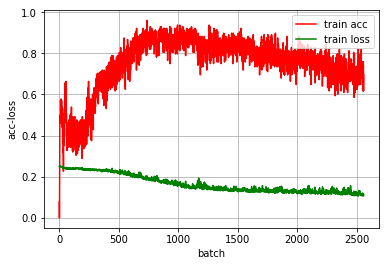

In [24]:
# 定义LSTM模型
model = Sequential()
model.add(LSTM(256, input_shape=(X.shape[1], X.shape[2])))
model.add(Dropout(0.2))
model.add(Dense(Y.shape[1], activation='sigmoid'))
model.compile(loss=losses.mean_squared_error, optimizer='adam',metrics=['accuracy'])
#创建一个实例history
history = LossHistory()

# print(model.summary())

# plot model
plot_model(model, to_file=r'./model.png', show_shapes=True)
# train model
epochs = 5
model.fit(X, Y, epochs=epochs, batch_size=128,callbacks=[history])
history.loss_plot('batch')

##### 模型

<img src="model1.png">

## Test 测试

In [25]:
for _ in range(100):
    start = np.random.randint(0, len(dataX)-1)
    # print(dataX[start])
    number1 = dataX[start][0:BINARY_DIM]
    number2 = dataX[start][BINARY_DIM:]
    print('='*30)
    print('%s: %s'%(number1, binary2int(number1)))
    print('%s: %s'%(number2, binary2int(number2)))
    sample = np.reshape(X[start], (1, 2*BINARY_DIM, 1))
    predict = np.round(model.predict(sample), 0).astype(np.int32)[0]
    print('%s: %s'%(predict, binary2int(predict)))

[1 0 1 1 0 0 1 0]: 178
[0 0 0 0 1 0 1 1]: 11
[0 1 0 1 1 0 1 0 1]: 181
[0 0 1 0 0 1 0 1]: 37
[1 1 0 0 0 0 1 1]: 195
[0 1 1 1 1 1 1 1 0]: 254
[0 1 0 0 1 1 1 1]: 79
[0 1 0 0 0 1 0 1]: 69
[0 1 0 0 1 0 1 0 0]: 148
[1 1 0 1 1 0 1 1]: 219
[1 1 0 1 0 0 0 1]: 209
[1 1 0 1 1 1 0 0 0]: 440
[1 0 1 1 0 0 1 1]: 179
[0 1 1 1 0 1 0 0]: 116
[1 0 0 1 1 0 0 0 1]: 305
[1 0 1 0 0 1 1 0]: 166
[1 1 0 0 1 0 0 0]: 200
[1 0 1 1 0 1 0 1 0]: 362
[0 1 0 1 0 1 1 1]: 87
[1 1 0 1 0 1 1 1]: 215
[1 0 0 1 1 0 1 0 0]: 308
[1 1 1 0 0 0 0 1]: 225
[1 0 0 1 0 1 0 1]: 149
[1 0 1 1 1 1 0 0 0]: 376
[1 1 0 1 1 1 1 1]: 223
[0 0 1 1 1 1 0 0]: 60
[1 0 0 0 1 0 1 0 1]: 277
[1 1 0 1 1 1 1 0]: 222
[1 1 0 0 0 1 1 0]: 198
[1 1 0 0 1 0 0 0 0]: 400
[0 0 1 0 0 1 0 1]: 37
[1 0 1 1 0 1 0 1]: 181
[0 1 1 0 1 0 1 1 0]: 214
[1 0 0 0 0 1 1 1]: 135
[0 1 0 0 0 1 0 0]: 68
[0 1 1 0 0 0 1 0 1]: 197
[0 0 0 0 1 1 1 1]: 15
[1 1 1 1 1 0 0 1]: 249
[1 0 0 0 0 0 1 0 0]: 260
[0 1 1 0 0 1 1 1]: 103
[1 1 1 1 0 1 1 0]: 246
[1 0 1 0 0 1 0 1 1]: 331
[0 0 1 0 0 1 1 